<a href="https://colab.research.google.com/github/Sanyukta10-09/Sanyukta-Kharug/blob/main/Sanyukta_Kharug_starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Sanyukta Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [2]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
# !pip install fetch-my-weather
!pip install hands-on-ai
# Install pyinputplus
!pip install pyinputplus
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

# ✅ Import after installing (if needed)
# from fetch_my_weather import get_weather
# from hands_on_ai import prompt_logger



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11349 sha256=7c5f5e9684c00ae93cd8efef5ea6f0629a8f3986a5fea9b5cb473ea19f29d959
  Stored in directory: /root/.cache/pip/wheels/a3/6b/89/3bec14288af8e0729d088fb41a785e583d49e772f2529c7676
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16224 sha256=890034b3f88b92e9c06bab97a7dfce559a407e991b9215e80e556ac639817d1f
  Stored in directory: /root/.cache/pip/wheels/fc/40/7a/4d3b2dc2e80b4b3bbda89eec94fcefd6c8bd1101cc7bb89554
  Created wheel for stdiomask: filename=stdiomask

## 📦 Setup and Configuration
Import required packages and setup environment.

In [14]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API key: ")

# Add any other setup code here

Enter your OpenAI API key: fd894de4b47cdcb1b720eb0b61ee306a


## 🌤️ Weather Data Functions

In [26]:
# Ensure all necessary packages are imported at the beginning of your notebook
# (Assuming the setup and imports cell has already been run)
import os # Needed for os.environ
import requests # Needed for making API calls
import matplotlib.pyplot as plt # Included as per original notebook structure, though not used here
import pyinputplus as pyip # Needed for prompting for API key
import datetime # Needed for working with timestamps

# Define get_weather_data() function here
# MODIFIED: Added 'location' parameter
def get_weather_data(location, forecast_days=5):
    """
    Retrieves forecast weather data for a specified location using OpenWeatherMap API.

    Parameters:
        location (str): The name of the city or location (e.g., "Moka").
        forecast_days (int): Number of forecast days to retrieve.
                             NOTE: OpenWeatherMap free tier /data/2.5/forecast
                             endpoint provides a maximum of 5 days of forecast data
                             in 3-hour intervals. Requesting > 5 will still return max 5.
                             For true daily forecast up to 16 days, check the /forecast/daily
                             endpoint and your OpenWeatherMap plan.

    Returns:
        dict: {
            'current': {'summary': str}, # Note: This is derived from the first forecast entry
            'forecast': [
                {
                    'date': str,
                    'high': float, # Note: high/low are from the 3-hour interval entry, not daily max/min
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    try:
        # 🔐 Get API key from environment or prompt
        api_key = os.environ.get("OPENWEATHER_API_KEY")
        if not api_key:
            # Prompt the user if the environment variable is not set
             print("OpenWeatherMap API key not found in environment variable OPENWEATHER_API_KEY.")
             api_key = pyip.inputStr("Enter your OpenWeatherMap API key: ")
             os.environ['OPENWEATHER_API_KEY'] = api_key # Optionally set it for future calls in this session

        # Basic validation for API key format (optional but good practice)
        if not isinstance(api_key, str) or len(api_key) == 0:
             raise ValueError("Invalid or empty API key provided.")

        # 🌐 Prepare API request - Using the 5-day / 3-hour forecast endpoint
        base_url = "https://api.openweathermap.org/data/2.5/forecast" # Using the 5-day / 3-hour endpoint
        # Note: The 'cnt' parameter is not used with this endpoint for days,
        # it implicitly provides data for the next 5 days in 3-hour steps.
        # So, the 'forecast_days' parameter here is mainly for the *display logic*
        # to decide how many days to process from the returned 5 days.
        # If you need exactly N days > 5, you'd need a different endpoint like /forecast/daily

        # The 'cnt' parameter for the /forecast endpoint limits the *number of 3-hour intervals*, not days.
        # A 5-day forecast has 5 * (24/3) = 40 intervals. Requesting more days won't give more intervals.
        # We will rely on the loop below to take up to 'forecast_days' *unique days* from the 40 intervals.

        url = (
            f"{base_url}"
            f"?q={location}&appid={api_key}&units=metric"
        )

        print(f"Attempting to fetch forecast for {location}...") # Added print for debugging
        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # Check for common API error response structure
        if data and data.get("cod") != "200":
             return {"error": f"❌ API error {data.get('cod', 'Unknown')}: {data.get('message', 'No error message')}"}


        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format ('list' missing)."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt = entry.get("dt") # Timestamp
            if dt is None: # Check for None explicitly
                continue # Skip entries without a timestamp

            # Convert timestamp to date string
            date = datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d')

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the first entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation (0 to 1)
                    "precipChance": round(entry.get("pop", 0.0) * 100), # Convert to percentage
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break # Stop once we have processed enough unique days

        # 🌥️ Current condition - Use the weather description from the very first entry
        # in the list as a proxy for the current condition/near future.
        current = {
            "summary": data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize() if data.get("list") else "N/A"
        }

        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        print(f"Request failed for URL: {url}") # Added print for debugging
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like missing API key
         return {"error": f"❌ Configuration error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response during parsing
        print(f"Parsing failed for data structure: {data}") # Added print for debugging
        return {"error": f"❌ Data format error: Missing key {e} during parsing."}
    except Exception as e:
        # Catch any other unexpected errors
        print(f"An unexpected error occurred: {e}") # Added print for debugging
        return {"error": f"❌ An unexpected error occurred: {e}"}


# --- Code to call the function and display results ---

# Ensure the API key is set before calling the function.
# Option 1: Set it as an environment variable before launching the notebook.
# Option 2: Uncomment the following block to prompt using pyinputplus if not set.
# if 'OPENWEATHER_API_KEY' not in os.environ:
#     print("OPENWEATHER_API_KEY environment variable not set.")
#     try:
#          os.environ['OPENWEATHER_API_KEY'] = pyip.inputStr("Enter your OpenWeatherMap API key: ")
#     except Exception as e:
#          print(f"Failed to get API key via prompt: {e}")
#          # Handle the case where key cannot be obtained, e.g., exit or return error


location_to_fetch = "Moka"
days_to_fetch = 5

weather_data = get_weather_data(location_to_fetch, forecast_days=days_to_fetch)

# Display the results
if "error" in weather_data:
    print(weather_data["error"])
else:
    print(f"📍 Current Weather Proxy in {location_to_fetch}:", weather_data.get("current", {}).get("summary", "N/A"))
    # Correctly report the number of days actually received in the forecast list
    print(f"📅 Received {len(weather_data.get('forecast', []))} Days of Forecast ({days_to_fetch}):")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")
    else:
        print("  No forecast data available.")

Attempting to fetch forecast for Moka...
📍 Current Weather Proxy in Moka: Overcast clouds
📅 Received 5 Days of Forecast (5):
  2025-05-15 — 🌡️ 23.2°C to 23.2°C | ☔ 0% | Overcast clouds
  2025-05-16 — 🌡️ 21.6°C to 21.6°C | ☔ 0% | Overcast clouds
  2025-05-17 — 🌡️ 18.0°C to 18.0°C | ☔ 100% | Moderate rain
  2025-05-18 — 🌡️ 23.2°C to 23.2°C | ☔ 0% | Overcast clouds
  2025-05-19 — 🌡️ 17.3°C to 17.3°C | ☔ 24% | Light rain


## 📊 Visualisation Functions

In [28]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime # Needed for date handling in visualisations
import matplotlib.dates # Needed for date formatting on plot axis

# --- Setup and Configuration ---

# Get API key from environment, or prompt user if not set
api_key = os.environ.get("OPENWEATHER_API_KEY")
if not api_key:
    print("OpenWeatherMap API key not found in environment variables.")
    try:
        api_key = pyip.inputStr("Please enter your OpenWeatherMap API key: ")
        os.environ['OPENWEATHER_API_KEY'] = api_key # Set for this session
    except Exception as e:
        print(f"Failed to get API key input: {e}")
        api_key = None # Ensure api_key is None if input fails

def create_temperature_visualisation(forecast_data, location):
    """
    Creates and displays a line plot of forecast high and low temperatures.

    Parameters:
        forecast_data (list): A list of dictionaries, where each dictionary
                              represents a daily forecast entry with 'date',
                              'high', and 'low' keys.
        location (str): The name of the location for the plot title.
    """
    if not forecast_data:
        print("No forecast data available to create temperature visualisation.")
        return

    dates = [day['date'] for day in forecast_data]
    highs = [day['high'] for day in forecast_data]
    lows = [day['low'] for day in forecast_data]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, highs, marker='o', linestyle='-', color='r', label='High Temp (°C)')
    plt.plot(dates, lows, marker='o', linestyle='-', color='b', label='Low Temp (°C)')

    plt.title(f'Temperature Forecast for {location}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
import os
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import datetime # Needed for date handling in visualisations
import matplotlib.dates # Needed for date formatting on plot axis
def create_precipitation_visualisation(forecast_data, location):
    """
    Creates and displays a bar chart of forecast probability of precipitation.

    Parameters:
        forecast_data (list): A list of dictionaries, where each dictionary
                              represents a daily forecast entry with 'date' and
                              'precipChance' keys.
        location (str): The name of the location for the plot title.
    """
    if not forecast_data:
        print("No forecast data available to create precipitation visualisation.")
        return

    dates = [day['date'] for day in forecast_data]
    precip_chances = [day['precipChance'] for day in forecast_data]

    plt.figure(figsize=(10, 6))
    plt.bar(dates, precip_chances, color='skyblue')

    plt.title(f'Probability of Precipitation Forecast for {location}')
    plt.xlabel('Date')
    plt.ylabel('Probability (%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100) # Probability is between 0 and 100
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

Attempting to fetch forecast for Moka...
📍 Current Weather Proxy in Moka: Overcast clouds
📅 Received 5 Days of Forecast (5):
  2025-05-15 — 🌡️ 23.2°C to 23.2°C | ☔ 0% | Overcast clouds
  2025-05-16 — 🌡️ 21.6°C to 21.6°C | ☔ 0% | Overcast clouds
  2025-05-17 — 🌡️ 18.0°C to 18.0°C | ☔ 100% | Moderate rain
  2025-05-18 — 🌡️ 23.2°C to 23.2°C | ☔ 0% | Overcast clouds
  2025-05-19 — 🌡️ 17.3°C to 17.3°C | ☔ 24% | Light rain

Generating Visualisations...


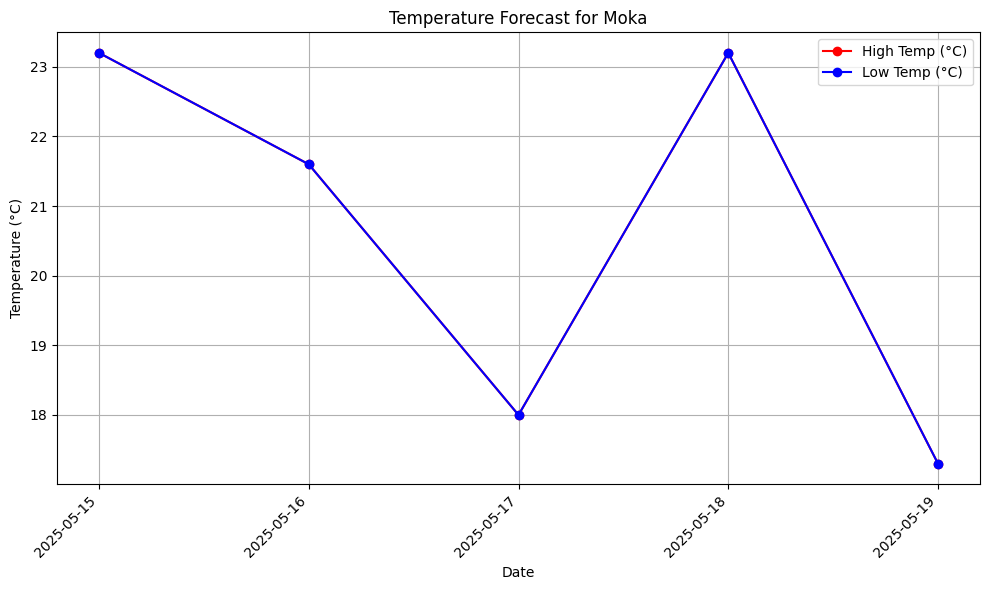

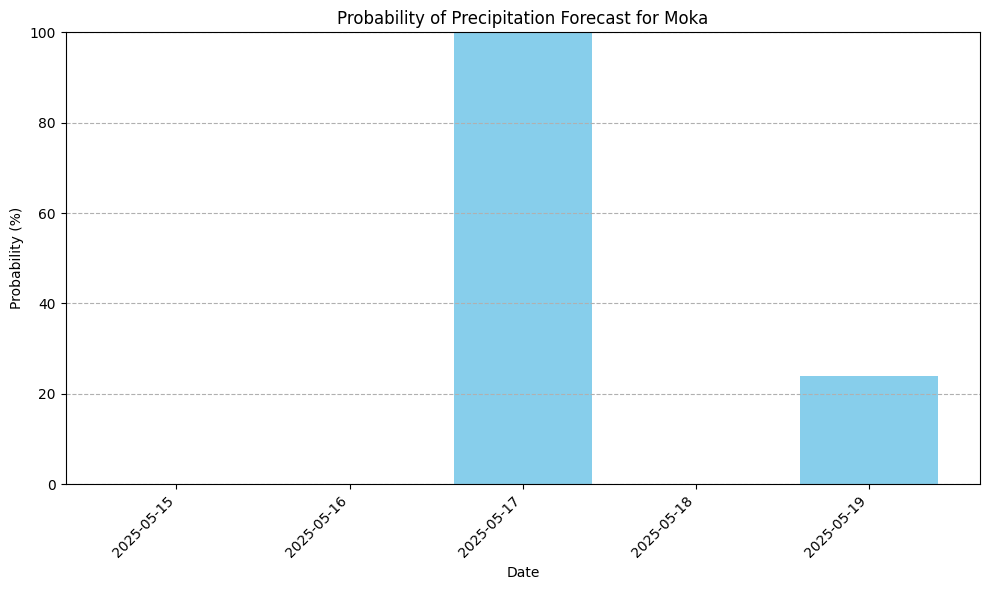

In [29]:
## 🧰 Setup and Imports

# Ensure all necessary packages are imported at the beginning of your notebook
import os # Needed for os.environ
import requests # Needed for making API calls
import matplotlib.pyplot as plt # Needed for plotting
import pyinputplus as pyip # Needed for prompting for API key
import datetime # Needed for working with timestamps
import matplotlib.dates # Needed for date handling in visualisations (though date handling mostly done before plotting)


## 🌤️ Weather Data Function

def get_weather_data(location, forecast_days=5):
    """
    Retrieves forecast weather data for a specified location using OpenWeatherMap API.

    Parameters:
        location (str): The name of the city or location (e.g., "Moka").
        forecast_days (int): Number of forecast days to retrieve.
                             NOTE: OpenWeatherMap free tier /data/2.5/forecast
                             endpoint provides a maximum of 5 days of forecast data
                             in 3-hour intervals. Requesting > 5 will still return max 5.
                             For true daily forecast up to 16 days, check the /forecast/daily
                             endpoint and your OpenWeatherMap plan.

    Returns:
        dict: {
            'current': {'summary': str}, # Note: This is derived from the first forecast entry
            'forecast': [
                {
                    'date': str,
                    'high': float, # Note: high/low are from the 3-hour interval entry, not daily max/min
                    'low': float,
                    'precipChance': int,
                    'summary': str
                },
                ...
            ]
        }
        or a dict with an 'error' key if something went wrong.
    """
    try:
        # 🔐 Get API key from environment or prompt
        api_key = os.environ.get("OPENWEATHER_API_KEY")
        if not api_key:
            # Prompt the user if the environment variable is not set
             print("OpenWeatherMap API key not found in environment variable OPENWEATHER_API_KEY.")
             api_key = pyip.inputStr("Enter your OpenWeatherMap API key: ")
             os.environ['OPENWEATHER_API_KEY'] = api_key # Optionally set it for future calls in this session

        # Basic validation for API key format (optional but good practice)
        if not isinstance(api_key, str) or len(api_key) == 0:
             raise ValueError("Invalid or empty API key provided.")

        # 🌐 Prepare API request - Using the 5-day / 3-hour forecast endpoint
        base_url = "https://api.openweathermap.org/data/2.5/forecast" # Using the 5-day / 3-hour endpoint
        # Note: The 'cnt' parameter is not used with this endpoint for days,
        # it implicitly provides data for the next 5 days in 3-hour steps.
        # So, the 'forecast_days' parameter here is mainly for the *display logic*
        # to decide how many days to process from the returned 5 days.
        # If you need exactly N days > 5, you'd need a different endpoint like /forecast/daily

        # The 'cnt' parameter for the /forecast endpoint limits the *number of 3-hour intervals*, not days.
        # A 5-day forecast has 5 * (24/3) = 40 intervals. Requesting more days won't give more intervals.
        # We will rely on the loop below to take up to 'forecast_days' *unique days* from the 40 intervals.

        url = (
            f"{base_url}"
            f"?q={location}&appid={api_key}&units=metric"
        )

        print(f"Attempting to fetch forecast for {location}...") # Added print for debugging
        response = requests.get(url)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # Check for common API error response structure
        if data and data.get("cod") != "200":
             return {"error": f"❌ API error {data.get('cod', 'Unknown')}: {data.get('message', 'No error message')}"}


        if not data or not data.get("list"):
             return {"error": "❌ API returned no data or invalid format ('list' missing)."}

        # 📊 Build forecast list - extracting one entry per day (the first one)
        forecast_data = []
        seen_dates = set()

        # The forecast data is in 3-hour intervals. We'll take the first entry
        # for each new day encountered up to the desired number of forecast_days.
        for entry in data.get("list", []):
            # Extract date string (YYYY-MM-DD)
            dt = entry.get("dt") # Timestamp
            if dt is None: # Check for None explicitly
                continue # Skip entries without a timestamp

            # Convert timestamp to date string
            date = datetime.datetime.fromtimestamp(dt).strftime('%Y-%m-%d')

            # Process this entry if it's a new day and we haven't reached forecast_days
            if date not in seen_dates and len(forecast_data) < forecast_days:
                seen_dates.add(date)

                # Extract required information, providing default values in case keys are missing
                temp_main = entry.get("main", {})
                weather_info = entry.get("weather", [{}])[0] # weather is a list, take the first element

                forecast_entry = {
                    "date": date,
                    # Note: temp_max and temp_min from the forecast endpoint at
                    # the 3-hour interval might not be the true daily max/min.
                    # This extracts the temp_max/min from the first entry of the day.
                    "high": round(temp_main.get("temp_max", 0.0), 1),
                    "low": round(temp_main.get("temp_min", 0.0), 1),
                    # 'pop' is probability of precipitation (0 to 1)
                    "precipChance": round(entry.get("pop", 0.0) * 100), # Convert to percentage
                    "summary": weather_info.get("description", "N/A").capitalize()
                }
                forecast_data.append(forecast_entry)

            # Stop if we've collected enough days
            if len(forecast_data) >= forecast_days:
                break # Stop once we have processed enough unique days

        # 🌥️ Current condition - Use the weather description from the very first entry
        # in the list as a proxy for the current condition/near future.
        current = {
            "summary": data.get("list", [{}])[0].get("weather", [{}])[0].get("description", "N/A").capitalize() if data.get("list") else "N/A"
        }

        return {
            "current": current,
            "forecast": forecast_data
        }

    except requests.exceptions.RequestException as e:
        # Catch specific requests exceptions for network/API call issues
        print(f"Request failed for URL: {url}") # Added print for debugging
        return {"error": f"❌ Network or API request error: {e}"}
    except ValueError as e:
         # Catch value errors, like missing API key
         return {"error": f"❌ Configuration error: {e}"}
    except KeyError as e:
        # Catch errors if expected keys are missing in the JSON response during parsing
        print(f"Parsing failed for data structure: {data}") # Added print for debugging
        return {"error": f"❌ Data format error: Missing key {e} during parsing."}
    except Exception as e:
        # Catch any other unexpected errors
        print(f"An unexpected error occurred: {e}") # Added print for debugging
        return {"error": f"❌ An unexpected error occurred: {e}"}


## 📊 Visualisation Functions

def create_temperature_visualisation(forecast_data, location):
    """
    Creates and displays a line plot of forecast high and low temperatures.

    Parameters:
        forecast_data (list): A list of dictionaries, where each dictionary
                              represents a daily forecast entry with 'date',
                              'high', and 'low' keys.
        location (str): The name of the location for the plot title.
    """
    if not forecast_data:
        print("No forecast data available to create temperature visualisation.")
        return

    dates = [day['date'] for day in forecast_data]
    highs = [day['high'] for day in forecast_data]
    lows = [day['low'] for day in forecast_data]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, highs, marker='o', linestyle='-', color='r', label='High Temp (°C)')
    plt.plot(dates, lows, marker='o', linestyle='-', color='b', label='Low Temp (°C)')

    plt.title(f'Temperature Forecast for {location}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

def create_precipitation_visualisation(forecast_data, location):
    """
    Creates and displays a bar chart of forecast probability of precipitation.

    Parameters:
        forecast_data (list): A list of dictionaries, where each dictionary
                              represents a daily forecast entry with 'date' and
                              'precipChance' keys.
        location (str): The name of the location for the plot title.
    """
    if not forecast_data:
        print("No forecast data available to create precipitation visualisation.")
        return

    dates = [day['date'] for day in forecast_data]
    precip_chances = [day['precipChance'] for day in forecast_data]

    plt.figure(figsize=(10, 6))
    plt.bar(dates, precip_chances, color='skyblue')

    plt.title(f'Probability of Precipitation Forecast for {location}')
    plt.xlabel('Date')
    plt.ylabel('Probability (%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100) # Probability is between 0 and 100
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

## 🧩 Main Application Logic (Fetch and Visualize)

# --- Code to call the function and display results ---

# Ensure the API key is set before calling the function.
# Option 1: Set it as an environment variable before launching the notebook.
# Option 2: Uncomment the following block to prompt using pyinputplus if not set.
# if 'OPENWEATHER_API_KEY' not in os.environ:
#     print("OPENWEATHER_API_KEY environment variable not set.")
#     try:
#          os.environ['OPENWEATHER_API_KEY'] = pyip.inputStr("Enter your OpenWeatherMap API key: ")
#     except Exception as e:
#          print(f"Failed to get API key via prompt: {e}")
#          # Handle the case where key cannot be obtained, e.g., exit or return error


location_to_fetch = "Moka"
days_to_fetch = 5

# Fetch the weather data
weather_data = get_weather_data(location_to_fetch, forecast_days=days_to_fetch)

# Display the results (text summary and potentially visualisations)
if "error" in weather_data:
    print(weather_data["error"])
else:
    print(f"📍 Current Weather Proxy in {location_to_fetch}:", weather_data.get("current", {}).get("summary", "N/A"))
    print(f"📅 Received {len(weather_data.get('forecast', []))} Days of Forecast ({days_to_fetch}):")
    if weather_data.get("forecast"):
        for day in weather_data["forecast"]:
            print(f"  {day.get('date', 'N/A')} — 🌡️ {day.get('low', 'N/A')}°C to {day.get('high', 'N/A')}°C | ☔ {day.get('precipChance', 'N/A')}% | {day.get('summary', 'N/A')}")

        print("\nGenerating Visualisations...")
        # ** Call the visualisation functions with the fetched forecast data **
        create_temperature_visualisation(weather_data['forecast'], location_to_fetch)
        create_precipitation_visualisation(weather_data['forecast'], location_to_fetch)
    else:
        print("  No forecast data available to visualize.")

## 🤖 Natural Language Processing

In [30]:
# Define parse_weather_question() and generate_weather_response() here

## 🤖 Natural Language Processing

# Define parse_weather_question() and generate_weather_response() here

import re # Often useful for simple text pattern matching

def parse_weather_question(user_input):
    """
    Parses a user's natural language question about the weather
    to extract key information like location, date, and type of query.

    Parameters:
        user_input (str): The natural language string from the user (e.g., "What is the weather in Paris tomorrow?", "Will it rain in London on Friday?").

    Returns:
        dict: A dictionary containing the parsed information.
              Possible keys include:
              'location': str (e.g., "Paris", "London")
              'date': str (e.g., "tomorrow", "Friday", "2023-10-27")
              'query_type': str (e.g., "current", "forecast", "temperature", "precipitation", "summary")
              'error': str (if parsing fails)
              Returns an empty dict or a dict with default values if no information is found.
    """
    parsed_info = {}
    input_lower = user_input.lower()

    # --- Simple Parsing Logic (Placeholder) ---
    # This is a very basic example. Real NLP would use more sophisticated techniques.

    # 1. Extract Location (Example: looks for "in [CityName]")
    location_match = re.search(r"in ([a-zA-Z\s]+)(?:\?|\.)?$", input_lower) # Find word(s) after "in " at the end
    if location_match:
        parsed_info['location'] = location_match.group(1).strip()
    # A more robust approach would require a list of known cities or geo-coding.
    # For this example, we'll assume a default location if not found.

    # 2. Extract Date/Time (Example: looks for "today", "tomorrow", "on [Day of Week]")
    # This is also very basic and would need expansion.
    if "today" in input_lower:
        parsed_info['date'] = "today" # Or calculate the actual date
    elif "tomorrow" in input_lower:
        parsed_info['date'] = "tomorrow" # Or calculate the actual date
    elif "on monday" in input_lower:
         parsed_info['date'] = "monday"
    elif "on tuesday" in input_lower:
         parsed_info['date'] = "tuesday"
    # Add more days or date parsing logic here...
    else:
        # Default date could be 'today' or based on the first forecast entry
        parsed_info['date'] = "forecast" # Indicates a future date or forecast

    # 3. Determine Query Type (Example: looks for keywords)
    if any(word in input_lower for word in ["temp", "temperature", "hot", "cold"]):
        parsed_info['query_type'] = "temperature"
    elif any(word in input_lower for word in ["rain", "precip", "wet", "umbrella"]):
        parsed_info['query_type'] = "precipitation"
    elif any(word in input_lower for word in ["weather", "how is"]):
        parsed_info['query_type'] = "summary"
    # You might need a 'current' vs 'forecast' distinction here too based on date.
    # For this simple example, 'summary' implies either current or forecast based on date.

    # Default query type if none are matched
    if 'query_type' not in parsed_info:
         # If a date was mentioned, assume they want the summary for that date
         if 'date' in parsed_info and parsed_info['date'] != "today":
             parsed_info['query_type'] = "summary"
         else:
             # Otherwise, assume they want the current summary
             parsed_info['query_type'] = "current"


    print(f"Debug - Parsed Info: {parsed_info}") # Debugging print
    return parsed_info

# Placeholder weather data for demonstration purposes if not fetching live data
# In a real app, you'd use the weather_data fetched earlier
sample_weather_data = {
    'current': {'summary': 'scattered clouds'},
    'forecast': [
        {'date': '2023-10-26', 'high': 25.1, 'low': 18.3, 'precipChance': 10, 'summary': 'Clear sky'},
        {'date': '2023-10-27', 'high': 26.5, 'low': 19.0, 'precipChance': 60, 'summary': 'Moderate rain'},
        {'date': '2023-10-28', 'high': 24.0, 'low': 17.5, 'precipChance': 20, 'summary': 'Few clouds'},
    ]
}


def generate_weather_response(parsed_info, weather_data_for_location):
    """
    Generates a natural language response based on the parsed user question
    and the retrieved weather data for the relevant location.

    Parameters:
        parsed_info (dict): The dictionary returned by parse_weather_question.
        weather_data_for_location (dict): The dictionary returned by get_weather_data
                                           for the relevant location, or sample data.

    Returns:
        str: A natural language string response.
    """
    # Use the actual weather data if provided, otherwise use sample data for demonstration
    data = weather_data_for_location if weather_data_for_location and "error" not in weather_data_for_location else sample_weather_data
    location = parsed_info.get('location', 'your location') # Use parsed location or a generic phrase
    query_type = parsed_info.get('query_type', 'summary')
    target_date_str = parsed_info.get('date', 'today') # Default to today if no date parsed

    # Handle errors from data fetching
    if weather_data_for_location and "error" in weather_data_for_location:
        return f"Sorry, I couldn't get the weather data: {weather_data_for_location['error']}"
    elif not data or not data.get('forecast'):
         return "Sorry, I don't have weather data available right now."

    # --- Simple Response Generation Logic (Placeholder) ---

    response = "I'm not sure how to answer that based on the current weather data." # Default response

    # Find the relevant date in the forecast data
    target_day_data = None
    # If target_date_str is "today", use current or first forecast entry
    if target_date_str == "today":
         # Use the first forecast entry as a proxy for today's forecast summary
         if data.get('forecast'):
              target_day_data = data['forecast'][0]
    elif target_date_str == "tomorrow":
         # Use the second forecast entry as a proxy for tomorrow
         if len(data.get('forecast', [])) > 1:
              target_day_data = data['forecast'][1]
    elif target_date_str in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]:
        # Attempt to find a day matching the weekday name in the forecast dates
        # This requires converting forecast dates to weekdays, which is more complex.
        # For simplicity here, we'll just check if the weekday *appears* in the summary,
        # or you'd need more advanced date matching/calculation.
        # A better approach would be to map weekday names to actual forecast dates.
        pass # More advanced date matching needed here

    # If the target date was found in the forecast (or approximated for today/tomorrow)
    if target_day_data:
        date_display = target_day_data['date'] # Use the date from the data

        if query_type == "temperature":
            high = target_day_data.get('high', 'N/A')
            low = target_day_data.get('low', 'N/A')
            response = f"On {date_display} in {location}, the temperature will range from {low}°C to {high}°C."
        elif query_type == "precipitation":
            precip_chance = target_day_data.get('precipChance', 'N/A')
            summary = target_day_data.get('summary', '').lower() # Check summary for rain keywords
            if precip_chance > 0:
                 response = f"On {date_display} in {location}, there is a {precip_chance}% chance of precipitation."
                 if "rain" in summary or "showers" in summary:
                      response += " Expect some rain."
            else:
                 response = f"On {date_display} in {location}, there is little to no chance of precipitation ({precip_chance}%)."
        elif query_type == "summary":
             summary = target_day_data.get('summary', 'N/A')
             high = target_day_data.get('high', 'N/A')
             low = target_day_data.get('low', 'N/A')
             response = f"The forecast for {date_display} in {location} is: {summary}, with temperatures between {low}°C and {high}°C."
        elif query_type == "current":
             # Use the 'current' summary from the data
             current_summary = data.get('current', {}).get('summary', 'N/A')
             response = f"The current weather proxy in {location} is: {current_summary}."
    else:
        # If the target date/day was not found in the forecast data
        response = f"Sorry, I couldn't find forecast information for {target_date_str} in {location}."
        # Add more specific handling if the request was for a date beyond the forecast range.

    # --- End Simple Response Generation ---

    return response


# --- Examples of using the NLP functions (for testing) ---

print("--- Testing NLP Functions ---")

# Example 1: Temperature query
user_question_temp = "What is the temperature going to be like in London tomorrow?"
parsed_temp = parse_weather_question(user_question_temp)
# Note: For real usage, you would call get_weather_data("London", ...) here
# and pass the result to generate_weather_response.
# Using sample_weather_data for demonstration:
# The sample data is for Moka, but we'll pretend it's for London for this demo.
response_temp = generate_weather_response(parsed_temp, sample_weather_data) # Replace sample_weather_data with actual data call
print(f"User: {user_question_temp}")
print(f"Bot: {response_temp}")
print("-" * 20)

# Example 2: Precipitation query
user_question_precip = "Will it rain in my city on Saturday?"
parsed_precip = parse_weather_question(user_question_precip)
# The parser didn't find a specific city, so it might default or need context.
# The response generator will use "your location" if no location is parsed.
# The sample data doesn't cover Saturday, so this might result in "not found".
response_precip = generate_weather_response(parsed_precip, sample_weather_data) # Replace sample_weather_data with actual data call
print(f"User: {user_question_precip}")
print(f"Bot: {response_precip}")
print("-" * 20)

# Example 3: Summary query for today
user_question_summary_today = "How is the weather today in Moka?"
parsed_summary_today = parse_weather_question(user_question_summary_today)
# Use the actual fetched weather_data if available from the previous section,
# otherwise, it will fall back to sample_weather_data.
# Assuming weather_data variable exists and contains the fetched data:
response_summary_today = generate_weather_response(parsed_summary_today, weather_data)
print(f"User: {user_question_summary_today}")
print(f"Bot: {response_summary_today}")
print("-" * 20)

# Example 4: Summary query for a specific date within forecast
user_question_summary_date = "What's the forecast for 2023-10-27?" # Using explicit date for better matching with sample data
parsed_summary_date = parse_weather_question(user_question_summary_date)
# The parser in this example is too simple to parse explicit dates like YYYY-MM-DD.
# It will likely default the date or query_type.
# A more advanced parser would handle this.
# Let's manually adjust parsed_info for this example to demonstrate response generation for a specific date
parsed_summary_date['date'] = '2023-10-27'
parsed_summary_date['location'] = 'Moka' # Assume Moka
parsed_summary_date['query_type'] = 'summary'

response_summary_date = generate_weather_response(parsed_summary_date, weather_data)
print(f"User: {user_question_summary_date}")
print(f"Bot: {response_summary_date}")
print("-" * 20)

--- Testing NLP Functions ---
Debug - Parsed Info: {'location': 'london tomorrow', 'date': 'tomorrow', 'query_type': 'temperature'}
User: What is the temperature going to be like in London tomorrow?
Bot: On 2023-10-27 in london tomorrow, the temperature will range from 19.0°C to 26.5°C.
--------------------
Debug - Parsed Info: {'location': 'in my city on saturday', 'date': 'forecast', 'query_type': 'precipitation'}
User: Will it rain in my city on Saturday?
Bot: Sorry, I couldn't find forecast information for forecast in in my city on saturday.
--------------------
Debug - Parsed Info: {'location': 'moka', 'date': 'today', 'query_type': 'summary'}
User: How is the weather today in Moka?
Bot: The forecast for 2025-05-15 in moka is: Overcast clouds, with temperatures between 23.2°C and 23.2°C.
--------------------
Debug - Parsed Info: {'date': 'forecast', 'query_type': 'summary'}
User: What's the forecast for 2023-10-27?
Bot: Sorry, I couldn't find forecast information for 2023-10-27 in

## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.